In [10]:
import numpy as np
import torch
from torch import nn
from utils import print_losses, load_dataset, train_model, train_step, test_step, train_SWAG
from utils import load_model, create_model, get_loaders, DATA_DIR, DATASETS, LR_SWAG, run_SWAG
from utils import get_test_predictions, RMSE, train_SWAG_mod, calculate_coeffs
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [11]:
# # SWAG LOOP

# for dataset_name in DATASETS:
#     run_SWAG(dataset_name)

dataset: boston_housing, rows: 506, columns: 13, range of x: [0.0, 711.0], range of y: [5.0, 50.0]
Finished Training. Best validation loss: 0.25219 in epoch 460
SGD RMSE: 0.437


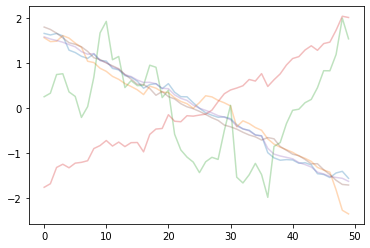

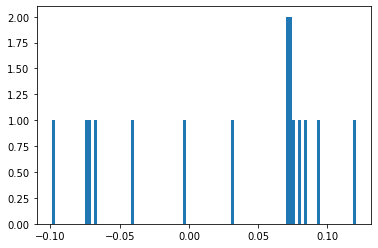

NameError: name 'sample_from_SWAG' is not defined

In [12]:
K = 10
S = 500
wd = 1e-6
# for dataset_name in ['boston_housing']:
# for dataset_name in ['yacht']:
# for dataset_name in ['year_prediction_msd']:
# for dataset_name in ['naval_compressor_decay']:
for dataset_name in DATASETS:
    print("=" * 88)
    x_train, y_train, x_test, y_test, _, _ = load_dataset(dataset_name)
    batch_size = x_train.shape[0]//9
    model = create_model(x_train, layer_dims=[1], verbose=False)
    train_model(x_train, y_train, x_test, y_test, model, dataset_name, lr=0.001, epochs=50000, verbose=False, batch_size=batch_size, weight_decay=wd)
    model = load_model(model, f"best_model_weights-{dataset_name}.pth", verbose=False)
    y_pred = get_test_predictions(x_train, y_train, x_test, y_test, model)
    print(f"SGD RMSE: {RMSE(y_pred, y_test):.3f}")
    for rounds in range(10):
        try:
            
            model = load_model(model, f"best_model_weights-{dataset_name}.pth", verbose=False)
            theta_swa, sigma_diag, D, thetas = train_SWAG_mod(x_train, y_train, x_test, y_test, model, K, 
                                                          verbose=False, lr=0.001, batch_size=batch_size, 
                                                          weight_decay=wd, epochs=50)
            weight_series = torch.stack(thetas).numpy()
            step_plot = weight_series.shape[1] // 5
            weight_series -= weight_series.mean(axis=0, keepdims=True)
            weight_series /= weight_series.std(axis=0, keepdims=True)
            plt.plot(weight_series[:,::step_plot], alpha=0.3)
            plt.show()
            calculate_coeffs(weight_series, True)
            sigma_diag = torch.clamp(sigma_diag, min=1e-10)
            samples = sample_from_SWAG(x_train, y_train, x_test, y_test, model, theta_swa, sigma_diag, D, K, S)
            samples_array = np.concatenate(samples, axis=1)
            y_pred = samples_array.mean(axis=1, keepdims=True)
            y_l = np.percentile(samples_array, 2.5, axis=1, keepdims=True)
            y_u = np.percentile(samples_array, 97.5, axis=1, keepdims=True)
            print(f"RMSE: {RMSE(y_pred, y_test):.3f}, PICP: {np.mean((y_l < y_test) & (y_test < y_u)):.3f}, MPIW:{np.mean(y_u - y_l):.3f}")
        except Exception as e:
            raise e
            print("Some error")
    